# Structural Analysis

## Import Python modules and create results directory

In [1]:
import os
import pandas as pd
import numpy as np
import scipy.stats
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import shutil
from Bio.PDB.PDBParser import PDBParser
from Bio.PDB.PDBList import PDBList
from Bio.PDB.DSSP import DSSP
from Bio import SeqIO

rc_kwargs = {
    'legend.frameon': False,
    "font.size" : 11,
    "font.weight" : "normal"
}

plt.rcParams.update(**rc_kwargs)

FIG_OUTDIR = "results/manuscript_figures/"
OUTDIR = "results/spike_structure_analysis/"
if not os.path.exists(OUTDIR): os.mkdir(OUTDIR)

## Read in and process data on mutational effects

Read in mutational effects

In [2]:
mut_df_replicates = pd.read_csv('results/model-ch-sig-I-act/mut_df.csv')
mut_df_replicates.set_index('mutation', inplace=True)
mut_df_replicates.rename(columns={
    col : col.replace('Omicron_BA2', 'BA2')
    for col in mut_df_replicates
}, inplace=True)
mut_df_replicates.head()

,wts,sites,muts,0_beta,1_beta,avg_beta,0_S_Delta,1_S_Delta,avg_S_Delta,0_S_BA2,1_S_BA2,avg_S_BA2
mutation,,,,,,,,,,,,
A1015D,A,1015.0,D,-1.240629,-2.365959,-1.803294,0.030702,0.000000,0.015351,-0.0,-0.000000,0.000000
A1015S,A,1015.0,S,-0.194236,-0.136035,-0.165136,-0.000000,0.000000,0.000000,0.0,-0.000037,-0.000018
A1015T,A,1015.0,T,-1.828467,-1.701370,-1.764919,0.000000,1.490752,0.745376,-0.0,-0.000000,0.000000
A1015V,NaN,NaN,NaN,NaN,-4.209478,-4.209478,NaN,0.000000,0.000000,NaN,-0.000000,0.000000
A1016D,A,1016.0,D,-0.807699,NaN,-0.807699,0.000000,NaN,0.000000,0.0,NaN,0.000000


Compute site-wise summary statistics

In [3]:
same_fx = lambda x: x[0] if np.all(x == x[0]) else -1
cols_to_collapse = [col for col in mut_df_replicates.columns if "avg_" in col]
cols_to_collapse.extend(['sites']) #, 'BA1_wt', 'BA2_wt', 'Delta_wt', 'is_BA2_wt', 'is_Delta_wt'])
shifts_by_site = mut_df_replicates[cols_to_collapse].groupby("sites").agg(
    max_abs_S_BA2 = ('avg_S_BA2', lambda x: np.max(np.abs(x))),
    max_abs_S_Delta = ('avg_S_Delta', lambda x: np.max(np.abs(x))),
    
    mean_abs_S_BA2 = ('avg_S_BA2', lambda x: np.mean(np.abs(x))),
    mean_abs_S_Delta = ('avg_S_Delta', lambda x: np.mean(np.abs(x))),
    
    mean_S_BA2 = ('avg_S_BA2', np.mean),
    mean_S_Delta = ('avg_S_Delta', np.mean),
    
    sum_S_BA2 = ('avg_S_BA2',  np.sum),
    sum_S_Delta = ('avg_S_Delta', np.sum),
)

shifts_by_site.reset_index(inplace=True)
shifts_by_site["res_n"] = shifts_by_site["sites"].astype(int)
shifts_by_site.head()

,sites,max_abs_S_BA2,max_abs_S_Delta,mean_abs_S_BA2,mean_abs_S_Delta,mean_S_BA2,mean_S_Delta,sum_S_BA2,sum_S_Delta,res_n
0,1.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1
1,2.0,0.101169,0.000057,0.025292,0.000014,-0.025292,-0.000014,-0.101169,-0.000057,2
2,3.0,0.110149,0.081638,0.036175,0.013606,0.032394,0.013606,0.194364,0.081638,3
3,4.0,0.061520,0.117634,0.023644,0.042836,-0.023644,-0.035587,-0.070931,-0.106760,4
4,5.0,0.674212,0.278434,0.078759,0.077590,0.040040,-0.075968,0.720711,-1.367432,5


Read alignment of homologs, identify nonidentical sites in Delta and BA.2 relative to BA.1, using WH1 as the numbering reference, and add to data frame with site-level data.

In [4]:
# Read in alignment
alignment_file = 'data/clustalo-I20230702-193723-0021-19090519-p1m.clustal_num'
align_dict = {}
with open(alignment_file) as handle:
    for record in SeqIO.parse(handle, "clustal"):
        align_dict[record.id] = record.seq
        
# Identify non-identical sites realtive to BA.1
ref_seq = align_dict['WH1_QHD43416.1']
homologs = ['Delta', 'BA.2']
align_nis_dict = {
    homolog : []
    for homolog in homologs
}
align_gaps_dict = {
    homolog : []
    for homolog in homologs
}
for homolog in homologs:
    print(homolog)
    ref_n = 1
    n_diffs = 0
    for (n, (ref, i, j)) in enumerate(zip(ref_seq, align_dict['BA.1'], align_dict[homolog])):
        if i != j:
            
            # If the mut is an indel, then record it in the gap dict
            if (i == '-' or j == '-'):
                if True: # ref_n not in align_gaps_dict[homolog]:
                    align_gaps_dict[homolog].append(ref_n)
                pass # continue
            
            # Record the mut in the nis dict
            #print(ref_n, i, j)
            align_nis_dict[homolog].append(ref_n)
            n_diffs += 1
        if ref != '-':
            ref_n += 1
    print('n_diffs', n_diffs, 1-round(n_diffs/1254, 4))
    
# Add columns to shifts_by_site that indicate if a site is nonidentical
for homolog in ['Delta', 'BA.2']:
    hn = homolog.replace('.', '')
    shifts_by_site[f"is_{hn}_nis"] = shifts_by_site['res_n'].apply(lambda x: x in align_nis_dict[homolog])

Delta
n_diffs 43 0.9657
BA.2
n_diffs 27 0.9785


## Download structures from PDB and compute distance matrices between residues

In [5]:
def get_distance_matrix(structure, d_metric='interatomic'):

    # Get a list of residues, ignorning heteroatoms
    residues = [r for r in structure.get_residues() if r.get_id()[0] == " "]
    res_ns = []
    res_ids = []
    for res in residues:
        full_id = res.get_full_id()
        chain = full_id[2]
        res_n = ''.join(map(str, full_id[3][1:])).strip()
        if (res_n not in res_ns) and chain == 'A':
            res_ns.append(res_n)
        res_ids.append(f'{chain}_{res_n}')
        
    # Compute a distance matrix between all pairs of C-alpha carbons
    dist_dict = {
        key : []
        for key in ['res_n', 'res_id'] + res_ids
    }
    for res_i in residues:
        full_id_i = res_i.get_full_id()
        chain_i = full_id_i[2]
        res_n_i = ''.join(map(str, full_id_i[3][1:])).strip()
        dist_dict['res_n'].append(res_n_i)
        dist_dict['res_id'].append(f'{chain_i}_{res_n_i}')
        
        #print(res_n_i)
        
        for res_j in residues:
            full_id_j = res_j.get_full_id()
            chain_j = full_id_j[2]
            res_n_j = ''.join(map(str, full_id_j[3][1:])).strip()
            
            if d_metric == 'CA':
                xyz_i = res_i["CA"].get_coord()
                xyz_j = res_j["CA"].get_coord()
                d = np.linalg.norm(xyz_j-xyz_i)

            elif d_metric == 'interatomic':
                interatomic_dists = []
                for atom_i in res_i:
                    for atom_j in res_j:
                        interatomic_dists.append(atom_i-atom_j)
                d = min(interatomic_dists)
            
            else:
                raise ValueError(f'{d_metric} not recognized')
            
            dist_dict[f'{chain_j}_{res_n_j}'].append(d)
    dist_df = pd.DataFrame(dist_dict)
    
    return dist_df

For each input PDB, compute a distance matrix that quantifies the minimum inter-atomic distance between all atom pairs from a given pair of residues. Since this takes a long time, save the results to a file and only rerun if the file doesn't exist.

In [6]:
# Make a list of PDBs to analyze, one per spike conformation
pdbs = ['7tf8', '7tl9', '7tge']

# Loop over PDBs and compute distance matrices for each
dfs = []
for pdb in pdbs:

    # Download structure
    print(pdb)
    pdbl = PDBList()
    pdbl.retrieve_pdb_file(pdb, pdir='results/', file_format='pdb')
    shutil.copy(f'results/pdb{pdb}.ent', f'results/pdb{pdb}.pdb')

    # Read in structure
    parser = PDBParser()
    structure = parser.get_structure(pdb, f'results/pdb{pdb}.ent')
    
    # Compute distance matrix and write to output file
    output_file = os.path.join(OUTDIR, f'{pdb}_dist_matrix.csv')
    if not os.path.isfile(output_file):
        df = get_distance_matrix(structure, d_metric='interatomic')
        print(f'Writing distance matrix for {pdb} to {output_file}')
        df.to_csv(output_file, index=False)

7tf8
Structure exists: 'results/pdb7tf8.ent' 


/home/hhaddox/miniconda3/envs/dmsa-pred/lib/python3.9/site-packages/Bio/PDB/StructureBuilder.py:89: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 26735.
  warnings.warn(
/home/hhaddox/miniconda3/envs/dmsa-pred/lib/python3.9/site-packages/Bio/PDB/StructureBuilder.py:89: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 26861.
  warnings.warn(
/home/hhaddox/miniconda3/envs/dmsa-pred/lib/python3.9/site-packages/Bio/PDB/StructureBuilder.py:89: PDBConstructionWarning: WARNING: Chain C is discontinuous at line 26945.
  warnings.warn(


7tl9
Structure exists: 'results/pdb7tl9.ent' 


/home/hhaddox/miniconda3/envs/dmsa-pred/lib/python3.9/site-packages/Bio/PDB/StructureBuilder.py:89: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 26146.
  warnings.warn(
/home/hhaddox/miniconda3/envs/dmsa-pred/lib/python3.9/site-packages/Bio/PDB/StructureBuilder.py:89: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 26272.
  warnings.warn(
/home/hhaddox/miniconda3/envs/dmsa-pred/lib/python3.9/site-packages/Bio/PDB/StructureBuilder.py:89: PDBConstructionWarning: WARNING: Chain C is discontinuous at line 26328.
  warnings.warn(


7tge
Structure exists: 'results/pdb7tge.ent' 


/home/hhaddox/miniconda3/envs/dmsa-pred/lib/python3.9/site-packages/Bio/PDB/StructureBuilder.py:89: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 22717.
  warnings.warn(
/home/hhaddox/miniconda3/envs/dmsa-pred/lib/python3.9/site-packages/Bio/PDB/StructureBuilder.py:89: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 22801.
  warnings.warn(
/home/hhaddox/miniconda3/envs/dmsa-pred/lib/python3.9/site-packages/Bio/PDB/StructureBuilder.py:89: PDBConstructionWarning: WARNING: Chain C is discontinuous at line 22913.
  warnings.warn(


Read in the distance matrices generated above.

In [7]:
# Read in data
dfs = []
for pdb in pdbs:
    output_file = os.path.join(OUTDIR, f'{pdb}_dist_matrix.csv')
    df = pd.read_csv(output_file)
    dfs.append(df)
dist_df = pd.concat(dfs)

# Ignore subset of sites
dist_df = dist_df[
    ~dist_df['res_n'].isin(['214A', '214B', '214C'])
].copy()
dist_df['res_n'] = dist_df['res_n'].astype(int)

/tmp/ipykernel_22613/2429129568.py:5: DtypeWarning: Columns (0) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(output_file)
/tmp/ipykernel_22613/2429129568.py:5: DtypeWarning: Columns (0) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(output_file)


Make an NxN matrix with the minimum distance between each pair of residues, considering all instances of a residue in a given trimer, and across all conformations being analyzed.

In [8]:
# First, collapse rows by site (ignoring chain),
# taking the min value across common entries
min_dist_df = dist_df.groupby('res_n').min()
min_dist_df.index.name = None
del min_dist_df['res_id']

# Then, transpose the dataframe and do that same
# as above, ignoring the same subset as above
min_dist_df = min_dist_df.T
min_dist_df['res_n'] = min_dist_df.apply(
    lambda row: row.name[2:],
    axis=1
)
min_dist_df = min_dist_df[
    ~min_dist_df['res_n'].isin(['214A', '214B', '214C'])
].copy()
min_dist_df['res_n'] = min_dist_df['res_n'].astype(int)

min_dist_df = min_dist_df.groupby('res_n').min()
print(len(min_dist_df.columns.values), len(min_dist_df.index))
#min_dist_df.reset_index(inplace=True)
min_dist_df.head()

1050 1050


,27,28,29,30,31,32,33,34,35,36,...,1138,1139,1140,1141,1142,1143,1144,1145,1146,1147
res_n,,,,,,,,,,,,,,,,,,,,,
27,0.000000,1.328904,4.245431,7.803918,10.194617,11.448770,15.332009,14.434987,16.023018,18.640284,...,102.017220,104.626976,102.632675,106.82467,108.72678,106.932130,107.868320,112.199770,112.679090,113.530846
28,1.328904,0.000000,1.330639,4.580856,7.445746,8.196696,12.871688,12.793999,14.942034,17.640210,...,98.292206,100.937540,98.946850,103.16498,105.01932,103.181260,104.182686,108.480705,108.910010,109.781880
29,4.245431,1.330639,0.000000,1.328879,3.527322,4.354058,9.152000,9.015921,11.517981,14.215644,...,95.802536,98.165650,96.114470,100.12144,102.42689,100.620860,101.098810,105.848724,106.450200,107.116600
30,7.803918,4.580856,1.328879,0.000000,1.330132,2.803801,5.024997,6.336913,9.055900,11.677278,...,90.171005,92.795710,90.595880,94.80444,96.75035,94.938385,95.792430,100.133660,100.818440,101.379420
31,10.194617,7.445746,3.527322,1.330132,0.000000,1.331625,3.376461,3.277251,5.656930,8.304296,...,92.130320,94.662930,92.350160,96.22634,98.58008,96.878500,97.333160,101.831340,102.864494,103.218980


Plot a contact map showing minimum inter-residue distances

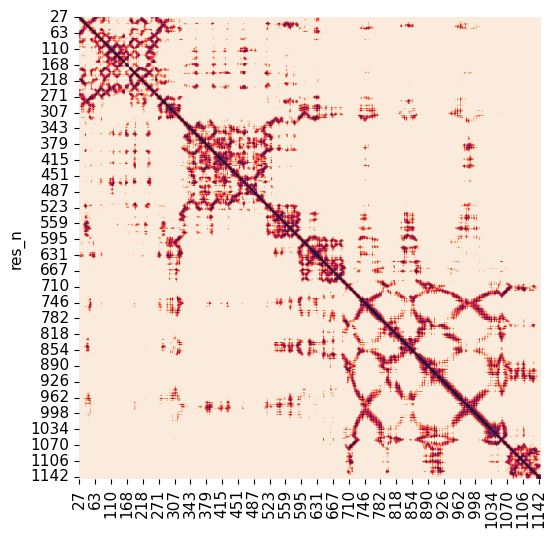

In [9]:
res_ns = sorted(min_dist_df.index.unique())
plt.figure(figsize=[6,6])
sns.heatmap(
    min_dist_df.loc[res_ns][res_ns],
    square=True, vmin=0, vmax=20, cbar=False,
)
plt.show()

Compute summary statistics quantifying the level of shifts in a neighborhood around a residue.

In [10]:
# Merge per-site data with distance matrix
data = shifts_by_site.merge(
    min_dist_df, on='res_n', how='inner'
)
print(len(shifts_by_site), len(min_dist_df), len(data))

# For each site, compute the average metric among
# all neighbors
metric_prefix ="max_abs_S"
nbr_dist_cutoff = 5
print(f'Using a neighbor distance cutoff of {nbr_dist_cutoff} Angstroms')
metrics = [f'{metric_prefix}_{h}' for h in ['Delta', 'BA2']]
nbr_score_dict = {
    key : []
    for key in ['res_n', 'n_nbrs'] + [f'nbr_{metric}' for metric in metrics]
}
for res_n in list(set(res_ns)):
    nbr_data = data[
        (data[res_n] < nbr_dist_cutoff) &
        (data['res_n'] != res_n)
    ]
    nbr_score_dict['res_n'].append(res_n)
    nbr_score_dict['n_nbrs'].append(len(nbr_data))
    for metric in metrics:
        nbr_score_dict[f'nbr_{metric}'].append(nbr_data[metric].mean())

nbr_score_df = pd.DataFrame(nbr_score_dict)
nbr_score_df = nbr_score_df.merge(data, on='res_n')

1235 1050 1044
Using a neighbor distance cutoff of 5 Angstroms


Plot the distribution of the number of neighbors per residue.

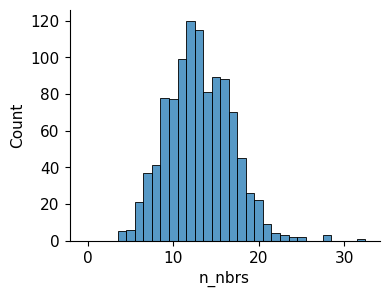

In [11]:
bins = np.arange(-0.5, nbr_score_df['n_nbrs'].max()+1.5, 1)
plt.figure(figsize=[4,3])
sns.histplot(x='n_nbrs', data=nbr_score_df, bins=bins)
sns.despine()
plt.show()

For each site, compute the nearest distance to a non-identical site

In [12]:
for homolog in ['BA2', 'Delta']:
    
    # Get a list of non-identical sites
    nis = nbr_score_df.query(f"is_{homolog}_nis == True")["res_n"]
    
    # Add a column that gives the minimum distance to non-identical
    # sites for a given homolog, not counting the query site, which
    # we achieve by ignoring entries of 0 in the distance matrix
    nbr_score_df[f"dist_nearest_{homolog}_nis"] = nbr_score_df.replace(0, np.nan)[nis].min(axis=1)

Save the results to an ouptut file.

In [13]:
nbr_score_df.to_csv(f"{OUTDIR}/nbr_score_df.csv", index=True)

Make plots analyzing the distribution shifts on the structure

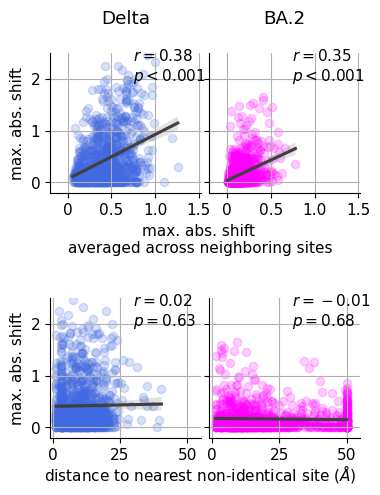

In [17]:
saveas=f"structural_statistics_{metric_prefix}"


fig = plt.figure(figsize=[4, 5])
axs = fig.subplot_mosaic(
    """
    bbbBBB
    cccCCC
    """,
#     height_ratios = [],
#     width_ratios = [],
#     empty_sentinel=".",
    gridspec_kw={
#         "wspace": 0.20,
        "hspace": 0.75,
    }
)

##################
# STRUCTURE IMAGES
##################

# axs["a"].axis("off")
# protein_image = Image.open("../data/delta_structure.jpg")
# axs["a"].imshow(protein_image)

# axs["A"].axis("off")
# protein_image = Image.open("../data/protein_structure.jpg")
# axs["A"].imshow(protein_image)


###############
# MAX V nbr MAX
###############

for homolog, iter_ax in zip(["Delta", "BA2"], ["b", "B"]):

    sns.regplot(
        data = nbr_score_df,
        y = f"{metric_prefix}_{homolog}",
        x = f"nbr_{metric_prefix}_{homolog}",
        ax=axs[iter_ax],
        scatter_kws = {
            "color":'royalblue' if homolog == "Delta" else "magenta",
            "s":35,
            "alpha":0.2,
        },
        line_kws={"color": "0.25"}
    )

    corr, p = scipy.stats.pearsonr(
        nbr_score_df[f"nbr_{metric_prefix}_{homolog}"], 
        nbr_score_df[f"{metric_prefix}_{homolog}"]
    )
    p = round(p, 3)
    p = f"p={p}" if p != 0 else "p<0.001"
    axs[iter_ax].annotate(
        f"$r = {corr:.2f}$\n${p}$", 
        (0.55, 0.8), 
        xycoords="axes fraction", 
        fontsize=11
    )
    
    axs[iter_ax].set_ylim([-0.2, 2.5])
    axs[iter_ax].set_yticks([0, 1,2], labels = [0, 1,2])
    axs[iter_ax].set_xlim([-0.2, 1.52])
    axs[iter_ax].set_xticks([0, 0.5, 1.0, 1.5], labels = [0, 0.5, 1.0, 1.5])
    axs[iter_ax].set_title(homolog+"\n" if homolog == "Delta" else "BA.2\n")
    
    if homolog == "Delta":
        xlabel=f'{metric_prefix} \naveraged across neighboring sites'
        xlabel=f'max. abs. shift \naveraged across neighboring sites'
        axs[iter_ax].set_xlabel(xlabel)
        axs[iter_ax].xaxis.set_label_coords(1.0, -0.22)
        axs[iter_ax].set_ylabel("max. abs. shift")
    else:
        axs[iter_ax].set_yticklabels([])
        axs[iter_ax].set_xlabel(None)
        axs[iter_ax].set_ylabel(None)
        
    sns.despine(ax=axs[iter_ax])
    axs[iter_ax].grid()


###############
# MAX V nbr MAX
###############

for homolog, iter_ax in zip(["Delta", "BA2"], ["c", "C"]):
    
    data = nbr_score_df.query(f"dist_nearest_{homolog}_nis != 0").copy()
    data[f"dist_nearest_{homolog}_nis"].clip(upper=50, inplace=True)
    sns.regplot(
        data = data,
        y = f"{metric_prefix}_{homolog}",
        x = f"dist_nearest_{homolog}_nis",
        ax=axs[iter_ax],
        scatter_kws = {
            "color":'royalblue' if homolog == "Delta" else "magenta",
            "s":35,
            "alpha":0.2,
        },
        line_kws={"color": "0.25"}
    )
    corr, p = scipy.stats.pearsonr(
        nbr_score_df.query(f"dist_nearest_{homolog}_nis != 0")[f"dist_nearest_{homolog}_nis"], 
        nbr_score_df.query(f"dist_nearest_{homolog}_nis != 0")[f"{metric_prefix}_{homolog}"]
    )
    p = round(p, 2)
    p = f"p={p}" if p != 0 else "p<0.001"
    axs[iter_ax].annotate(
        f"$r={corr:.2f}$\n${p}$", 
        (0.55, 0.8),
        xycoords="axes fraction", 
        fontsize=11
    )

    axs[iter_ax].set_ylim([-0.2, 2.5])
    axs[iter_ax].set_yticks([0, 1,2], labels = [0, 1,2])
    
    axs[iter_ax].set_xlim([-1, 55])
    axs[iter_ax].set_xticks([0, 25, 50], labels = [0, 25, 50])
    
    
    if homolog == "Delta":
        xlabel = 'distance to nearest non-identical site ($\AA$)'
        axs[iter_ax].set_xlabel(xlabel)
        axs[iter_ax].xaxis.set_label_coords(1.0, -0.18)
        axs[iter_ax].set_ylabel(metric_prefix)
        axs[iter_ax].set_ylabel("max. abs. shift")
        
    else:
        axs[iter_ax].set_yticklabels([])
        axs[iter_ax].set_xlabel(None)
        axs[iter_ax].set_ylabel(None)
        
    sns.despine(ax=axs[iter_ax])
    axs[iter_ax].grid()

    
fig.savefig(f"{FIG_OUTDIR}/{saveas}.pdf",bbox_inches='tight')
fig.savefig(f"{FIG_OUTDIR}/{saveas}.png",bbox_inches='tight')
plt.show()

In [26]:
homolog = 'BA2'
nis = list(nbr_score_df.query(f"is_{homolog}_nis == True")["res_n"])
nbr_score_df[
    (nbr_score_df[f"dist_nearest_{homolog}_nis"] > 20) &
    (nbr_score_df[f'max_abs_S_{homolog}'] > 1.0)
][['res_n'] + nis]

,res_n,27,67,95,212,213,214,371,376,405,408,446,496,547,856,981
835,939,51.92476,57.339954,46.481007,42.532833,41.666515,38.014645,78.683310,73.87964,77.280200,70.66748,95.10485,87.904160,44.994488,34.194584,51.154340
923,1027,66.98266,75.759450,66.858740,67.018620,65.845146,63.185500,81.527580,75.14590,77.679924,71.07344,97.86807,91.000084,50.562670,35.860450,50.703888
959,1063,63.53280,69.854100,59.218910,57.269737,56.353920,52.972565,84.848076,79.21473,82.878250,76.33930,102.46095,95.387670,50.287174,37.942013,54.827507


In [39]:
dist_df[
    dist_df['res_n'] == 959
][['res_n', 'A_981']]

,res_n,A_981
861,959,22.847029
1914,959,39.281517
2964,959,31.285099
861,959,23.565630
1889,959,40.410034
2894,959,31.489687
841,959,24.037868
1683,959,39.349380
2488,959,32.187740
